<a href="https://colab.research.google.com/github/jeudicode/MCC-AP/blob/master/tareas/tarea1/Tarea1_Diego_Isla_Lopez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets
import os
from itertools import islice as take
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as vutils

from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url


# Ejercicio 1: Red de unidades de umbral lineal

**Programa y evalúa una red de neuronas con funciones de activación escalón unitario que aproxime la operación XNOR.**



In [166]:
def escalon(z):
    if z > 0.0:
        return 1.0
    else:
        return 0.0

In [167]:

def neurona(x, w, b):
  z = np.dot(w.T, x) + b
  a = escalon(z)

  return a

In [168]:
def multicapa(x, W1, b1, W2, b2):
  escv = np.vectorize(escalon)
  a = escv(np.dot(W1.T, x) + b1)
  return escv(np.dot(W2.T, a) + b2)

Definimos el vector objetivo para la compuerta XNOR de la siguiente manera:

In [169]:
y_xnor = [1., 0., 0., 1.]

Definimos el vector con las entradas posibles:

In [170]:
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])


Para la estructura de la red, utilizamos una muy similar a la requerida para la compuerta XOR. En este caso, en lugar de usar una neurona que aplique la operación NAND, utilizamos una que aplique la operación NOR, además de una neurona que aplique la operación OR en la última capa. 

Para esto, primero debemos obtener los pesos necesarios para la operación NOR y definir la salida esperada. En este caso, observamos que los pesos necesarios son -1 para ambas entradas con un sesgo de 1

In [171]:
W1_nor = np.array([-1, -1])
b1_nor = np.array([1])
y_nor = np.array([1.,0.,0.,0.])

In [172]:
for i in range(X.shape[0]):
  y_hat = neurona(X[i], W1_nor, b1_nor)
  print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y_nor[i], y_hat))

0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	0.0	0.0


De este modo, sabemos que los pesos y sesgos para las compuertas necesarias son:

AND: W = [10, 10], b = -15

NOR: W = [-1, -1], b = 1

OR:  W = [10, 10], b = -5


Representamos esto en la estructura de la red:

In [173]:
W1 = np.array([[10, -1], [10, -1]])
b1 = np.array([-15, 1])

W2 = np.array([[10],[10]])
b2 = np.array([-5])

Se realiza la evaluación:

In [174]:
for i in range(X.shape[0]):
  y_hat = multicapa(X[i], W1, b1, W2, b2)
  print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y_xnor[i], y_hat[0]))

0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	1.0	1.0



# Ejercicio 2: Retropropagación en red densa

**Programa el algoritmo de retropropagación usando NumPy para una tarea de clasificación binaria presuponiendo un red densa con dos capas ocultas y la función de pérdida de entropía cruzada binaria. Describe las fórmulas y reglas de actualización de los pesos y sesgos de cada capa y entrena y evalúa la red en algún conjunto de datos.**

In [175]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

In [176]:
def derivada_sigmoide(x):
    return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

In [177]:
def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

In [178]:
def hacia_adelante(x, W1, b1, W2, b2):
    z2 = np.dot(W1.T, x[:, np.newaxis]) + b1
    a2 = sigmoide(z2)
    z3 = np.dot(W2.T, a2) + b2
    y_hat = sigmoide(z3)
    return z2, a2, z3, y_hat

In [179]:
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

In [180]:

def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]
        
    # Inicialización de las matrices de pesos W y V
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))
    
    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b2 = np.zeros((1, 1))
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, y_hat = hacia_adelante(X[j], W1, b1, W2, b2)

            # cálculo de gradientes para W2 y b2 por retropropagación
            dz3 = y_hat - y[j]
            dW2 = np.outer(a2, dz3)
            db2 = dz3

            # cálculo de gradientes para W1 y b1 por retropropagación
            dz2 = np.dot(W2, dz3) * derivada_sigmoide(z2)
            dW1 = np.outer(X[j], dz2)
            db1 = dz2
            
            ####################################
            # IMPORTANTE 
            # la actualización de los parámetros
            # debe hacerse de forma simultánea
            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2
            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[j] = y_hat
            
        # calcula la pérdida en la época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W1, W2, perdidas, exactitudes

Como ejemplo tomamos el caso de la compuerta XNOR del ejercicio anterior.  

In [181]:
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[1, 0, 0, 1]]).T

In [182]:
np.random.seed(0)
W1, W2, perdidas, exactitudes = retropropagacion(X, 
                                                 y, 
                                                 alpha = 1.0, 
                                                 n_epocas = 200,
                                                 n_ocultas = 3)

Epoch 0: Pérdida = 4.320250359446064 Exactitud = 50.0
Epoch 1: Pérdida = 4.284113802687309 Exactitud = 50.0
Epoch 2: Pérdida = 4.210590252906879 Exactitud = 50.0
Epoch 3: Pérdida = 4.130431969039492 Exactitud = 50.0
Epoch 4: Pérdida = 4.046857914326482 Exactitud = 50.0
Epoch 5: Pérdida = 3.961756610441059 Exactitud = 50.0
Epoch 6: Pérdida = 3.878697266200587 Exactitud = 50.0
Epoch 7: Pérdida = 3.8016154495588363 Exactitud = 50.0
Epoch 8: Pérdida = 3.733583917056392 Exactitud = 50.0
Epoch 9: Pérdida = 3.676256669847073 Exactitud = 50.0
Epoch 10: Pérdida = 3.629709411435489 Exactitud = 50.0
Epoch 11: Pérdida = 3.592722435930308 Exactitud = 50.0
Epoch 12: Pérdida = 3.563457621040582 Exactitud = 50.0
Epoch 13: Pérdida = 3.540091690191358 Exactitud = 50.0
Epoch 14: Pérdida = 3.521128907832548 Exactitud = 50.0
Epoch 15: Pérdida = 3.5054512044949138 Exactitud = 50.0
Epoch 16: Pérdida = 3.49225524345457 Exactitud = 50.0
Epoch 17: Pérdida = 3.480969276182552 Exactitud = 50.0
Epoch 18: Pérdida =

# 3. Regresión lineal con PyTorch

**Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que considere los dos atributos de entrada.**

Se carga el conjunto de datos de calificaciones:

In [183]:
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv'
base_dir = '../data/califs/'
filename = 'califs.csv'
filepath = os.path.join(base_dir, 'califs.csv')

download_url(URL, base_dir, filename)


Using downloaded and verified file: ../data/califs/califs.csv


In [184]:
df = pd.read_csv(filepath, names=['calif anterior','horas de estudio','calificación'])
df.head(5)

,calif anterior,horas de estudio,calificación
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770


Graficamos tomando en cuenta ambos atributos de entrada:

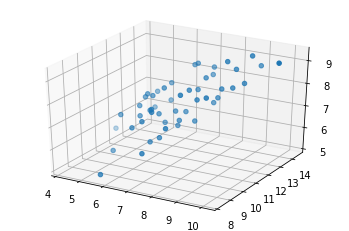

In [185]:
x_trn = np.array(df.iloc[:,0], dtype="float32")[..., np.newaxis]
y_trn = np.array(df.iloc[:,1], dtype="float32")[..., np.newaxis]
z_trn = np.array(df.iloc[:,2], dtype="float32")[..., np.newaxis]

ax = plt.axes(projection='3d')
ax.scatter3D(x_trn, y_trn, z_trn);


Creamos la clase del dataset tomando en cuenta los dos atributos:

In [186]:
class CalifDS:
    
    def __init__(self, X, Y, Z):
        self.x = X
        self.y = Y
        self.z = Z

    def __getitem__(self, i):
        X = np.array([self.x[i], self.y[i]]).flatten()
        y = self.z[i]

        return X, y

    def __len__(self):
        return len(self.z)

Probamos el funcionamiento del dataset:

In [187]:
batch_size = 16
ds = CalifDS(x_trn, y_trn, z_trn)
trn_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

print(ds.__getitem__(0))
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

(array([5.638, 8.289], dtype=float32), array([5.136], dtype=float32))
x shape=torch.Size([16, 2]) dtype=torch.float32
y shape=torch.Size([16, 1]) dtype=torch.float32


Utilizaremos las interfaces de alto y medio nivel, tomando en cuenta los dos atributos de entrada:

In [188]:
model_high = nn.Sequential(
    nn.Linear(2, 1)
)

In [189]:
class RegLin(nn.Module):
    def __init__(self):
        super(RegLin, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model_mid = RegLin()

Verificando:

In [190]:
print(model_high)
print(model_mid)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
RegLin(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


In [203]:
# inferencia con datos sintéticos
x = torch.zeros(2, 1).T
y_high = model_high(x)
y_mid = model_mid(x)
print(x.dtype, x.shape)
print(y_mid.dtype, y_mid.shape)
print(y_high.dtype, y_high.shape)

torch.float32 torch.Size([1, 2])
torch.float32 torch.Size([1, 1])
torch.float32 torch.Size([1, 1])


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.888
    momentum: 0
    nesterov: False
    weight_decay: 0
)
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

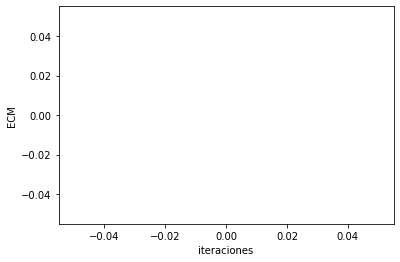

In [201]:
# optimizador
opt = optim.SGD(model_high.parameters(), lr=0.888)
print(opt)
#opt_mid = optim.SGD(model_mid.parameters(), lr=0.5)
#print(opt_mid)

# historial de pérdida
loss_hist_high = []
loss_hist_mid = []

# ciclo de entrenamiento
EPOCHS = 2000

# para alto nivel
for _ in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model_high(x)
        # print(y_lgts)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        loss_hist_high.append(loss.item() * 100)


print(loss_hist_high)
plt.plot(loss_hist_high, color='red')
plt.xlabel('iteraciones')
plt.ylabel('ECM');

# para nivel medio
opt = optim.SGD(model_mid.parameters(), lr=1)
for _ in range(EPOCHS):

    # entrenamiento de una época
    for x, y_true in trn_dl:
        # hacemos inferencia para obtener los logits
        y_lgts = model_mid(x)
        # print(y_lgts)
        # calculamos de pérdida
        loss = F.mse_loss(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()
        
        # guardamos historial de pérdida
        loss_hist_mid.append(loss.item() * 100)

#plt.plot(loss_hist_mid, color='blue')
#plt.xlabel('iteraciones')
#plt.ylabel('ECM');

# 4. Red completamente conectada con PyTorch

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguientes especificaciones:

* Explora con diferentes números de neuronas, capas, funciones de activación e hiperparámetros

* Discute tus resultados con las distintas configuraciones